## Loading the model and data

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = 'data/val'
VALIDATION_BATCH_SIZE = 64

In [ ]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 1050 images belonging to 21 classes.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope(
    {'GlorotUniform': glorot_uniform()}):
    model = load_model('model.h5')

## Preparing for the analysis


In [ ]:
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

1050
['agricultural/agricultural01.tif', 'agricultural/agricultural03.tif', 'agricultural/agricultural04.tif', 'agricultural/agricultural07.tif', 'agricultural/agricultural09.tif', 'agricultural/agricultural13.tif', 'agricultural/agricultural15.tif', 'agricultural/agricultural16.tif', 'agricultural/agricultural19.tif', 'agricultural/agricultural20.tif']


Checking the ground truth.

In [ ]:
ground_truth = validation_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
1050


In [ ]:
label_to_index = validation_generator.class_indices
print(label_to_index)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}


In [ ]:
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'agricultural', 1: 'airplane', 2: 'baseballdiamond', 3: 'beach', 4: 'buildings', 5: 'chaparral', 6: 'denseresidential', 7: 'forest', 8: 'freeway', 9: 'golfcourse', 10: 'harbor', 11: 'intersection', 12: 'mediumresidential', 13: 'mobilehomepark', 14: 'overpass', 15: 'parkinglot', 16: 'river', 17: 'runway', 18: 'sparseresidential', 19: 'storagetanks', 20: 'tenniscourt'}


In [ ]:
predictions = model.predict_generator(validation_generator,
                                      steps=None)

In [ ]:
print(predictions[:10])

[[9.98410821e-01 1.76204162e-06 1.36526054e-04 3.27796297e-05
  8.60725251e-08 3.12127486e-05 7.49413130e-06 1.13878259e-03
  7.08805737e-06 3.46746765e-06 6.24237946e-05 7.53153154e-06
  3.45747395e-07 1.22228776e-05 7.40376390e-06 2.15235195e-05
  5.33687262e-06 8.75695332e-05 4.69214314e-07 2.35819953e-05
  1.50553217e-06]
 [9.99326587e-01 1.38211715e-06 1.02864520e-04 1.45149206e-05
  9.37243883e-08 5.04205673e-05 1.21086923e-05 2.99646315e-04
  5.79111156e-06 2.03316017e-06 4.24178215e-05 1.91800882e-06
  2.07249457e-07 4.36193204e-06 7.47295144e-06 1.25453707e-05
  1.89991999e-06 1.02063437e-04 2.11262744e-07 8.91079981e-06
  2.50440507e-06]
 [7.25790560e-01 1.44074831e-04 3.52374115e-03 1.77698070e-03
  2.10933249e-05 3.06809810e-03 1.05408917e-03 2.26232544e-01
  1.01195590e-03 1.18123833e-03 1.82430055e-02 2.44324852e-04
  1.55645277e-04 9.73961898e-04 5.58706175e-04 3.61324684e-03
  1.92269858e-03 4.21849033e-03 4.93913481e-04 4.40251362e-03
  1.36916456e-03]
 [9.98825133e-01

In [ ]:
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [ ]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [ ]:
print(accuracy(prediction_index, ground_truth))

0.9123809523809524


In [ ]:
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [
        value_of_highest_probability, index_of_highest_probability,
        ground_truth[index]
    ]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [ ]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [ ]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

## Analysis

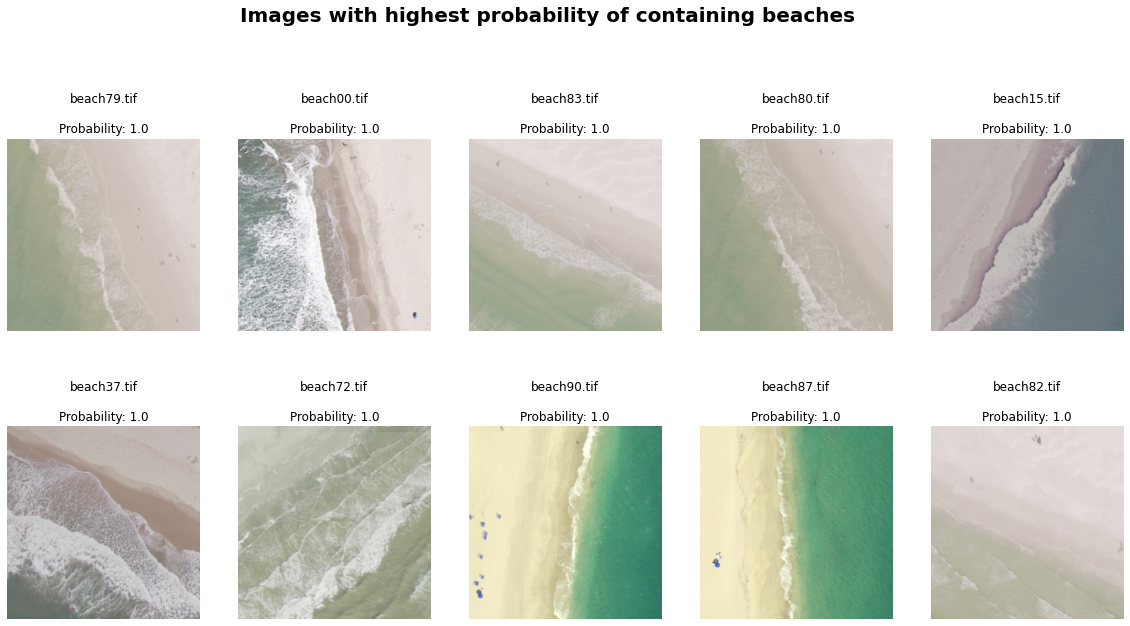

In [ ]:
most_confident_beach_images = get_images_with_sorted_probabilities(prediction_table, True, 3, 10,
                                               False)
message = 'Images with highest probability of containing beaches'
display(most_confident_beach_images, message)

### Least confident predictions of `beach`

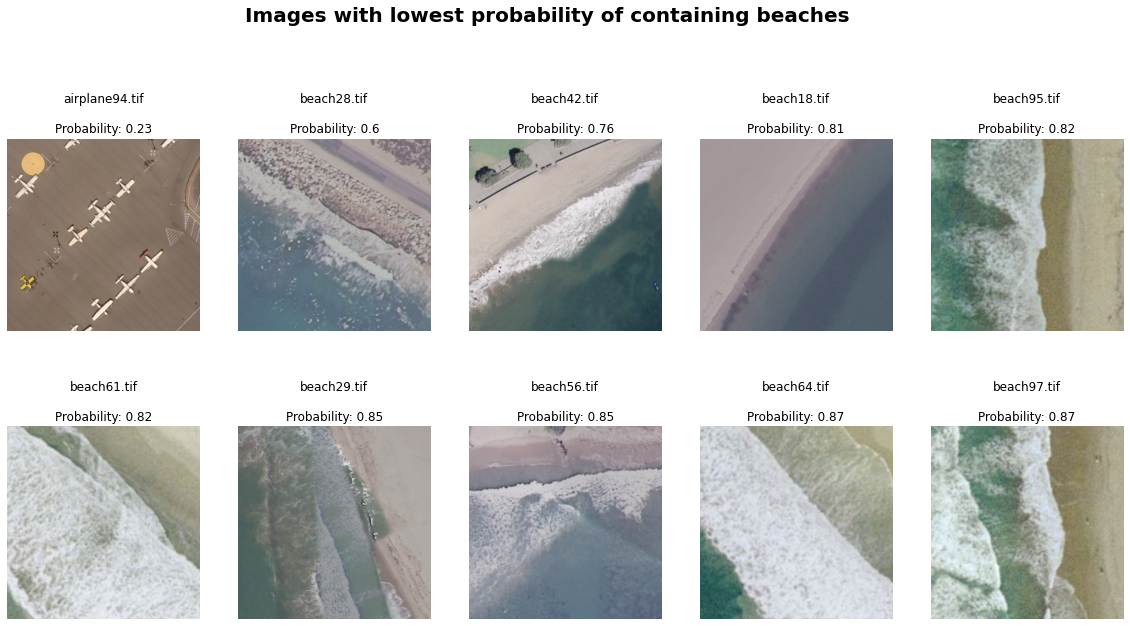

In [ ]:
least_confident_beach_images = get_images_with_sorted_probabilities(prediction_table, False, 3, 10,
                                               False)
message = 'Images with lowest probability of containing beaches'
display(least_confident_beach_images, message)

### Incorrect predictions of `beach`

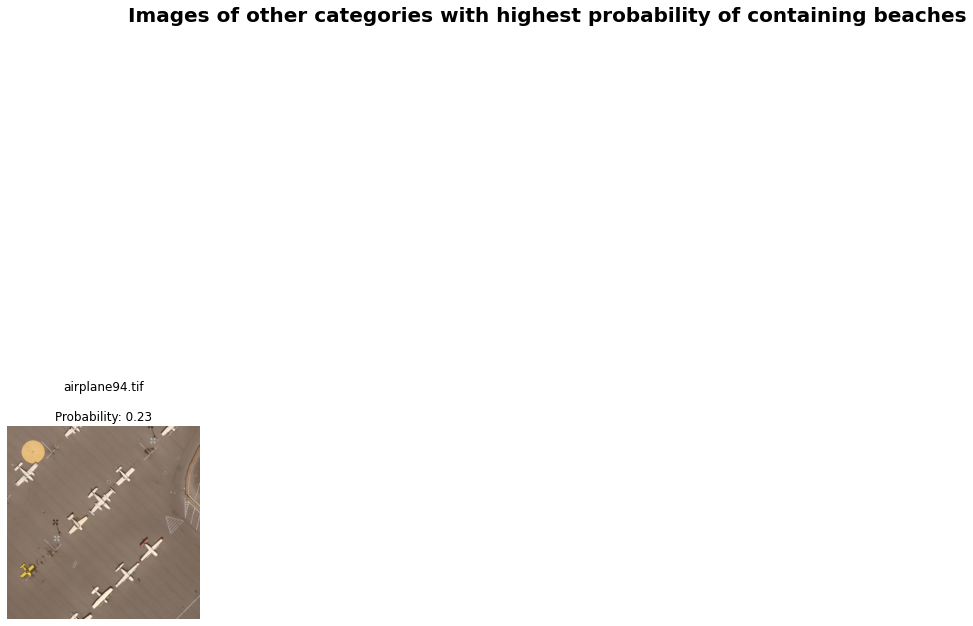

In [ ]:
incorrect_beach_images = get_images_with_sorted_probabilities(prediction_table, True, 3, 10,
                                               True)
message = 'Images of other categories with highest probability of containing beaches'
display(incorrect_beach_images, message)

### Most confident predictions of `golfcourse`

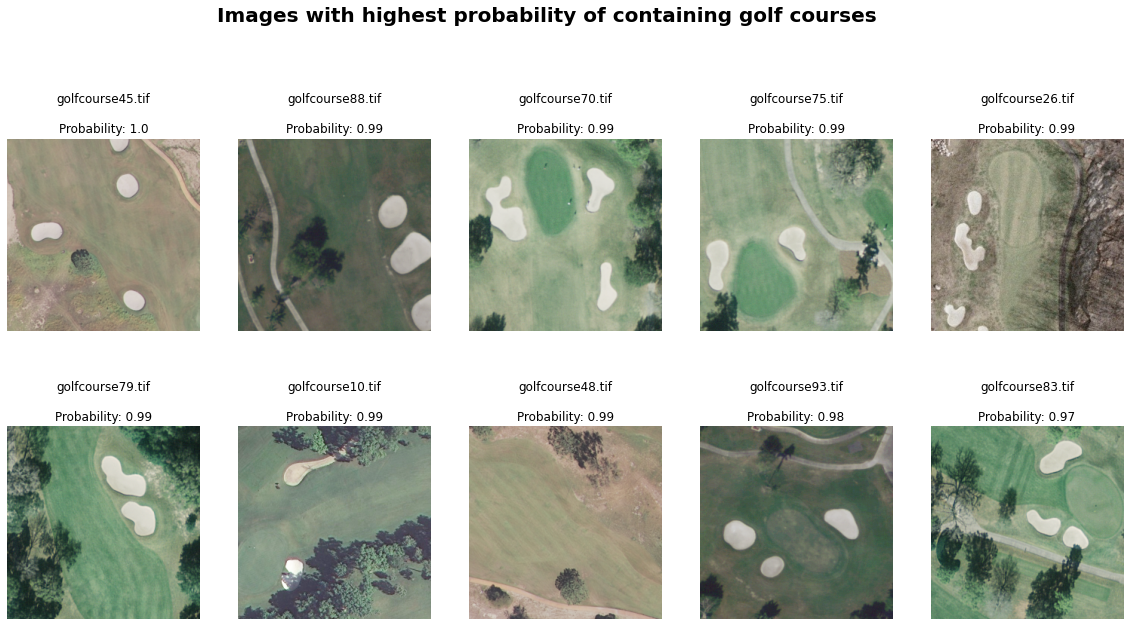

In [ ]:
most_confident_golfcourse_images = get_images_with_sorted_probabilities(prediction_table, True, 9, 10,
                                               False)
message = 'Images with highest probability of containing golf courses'
display(most_confident_golfcourse_images, message)

### Least confident predictions of `golfcourse`

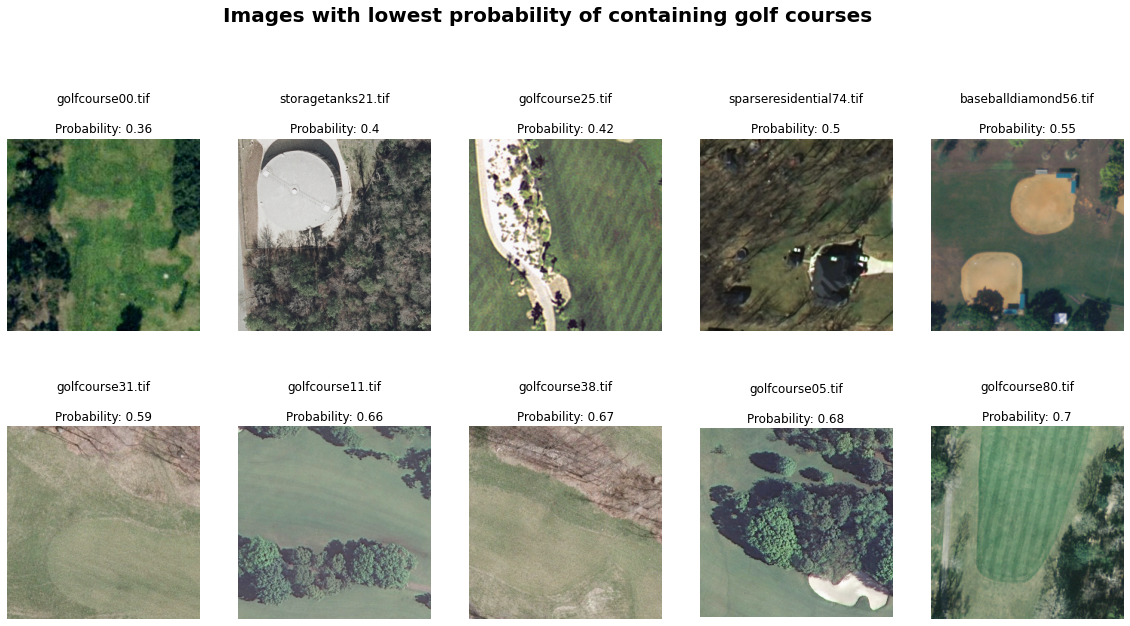

In [ ]:
least_confident_golfcourse_images = get_images_with_sorted_probabilities(prediction_table, False, 9, 10,
                                               False)
message = 'Images with lowest probability of containing golf courses'
display(least_confident_golfcourse_images, message)

### Incorrect predictions of `golfcourse`

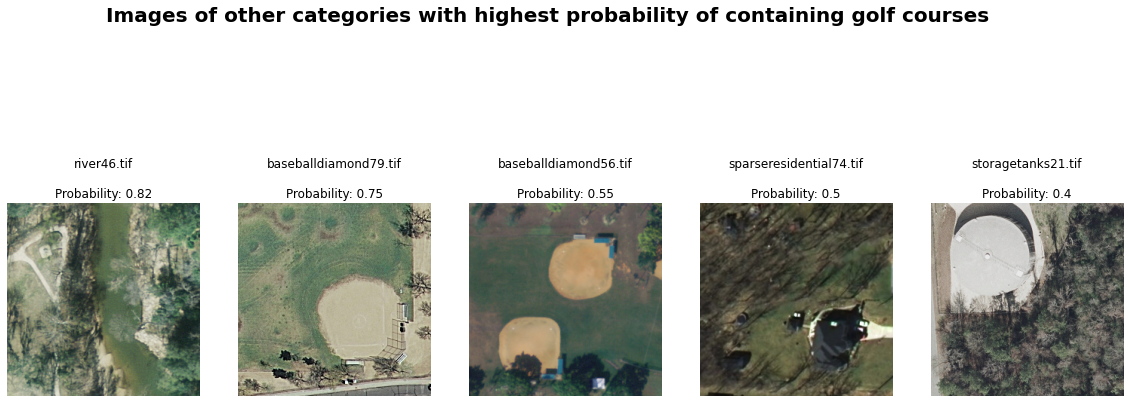

In [ ]:
incorrect_golfcourse_images = get_images_with_sorted_probabilities(prediction_table, True, 9, 10,
                                               True)
message = 'Images of other categories with highest probability of containing golf courses'
display(incorrect_golfcourse_images, message)